In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from colour import Color
import matplotlib.ticker as mtick

db_filename = 'dinofunworld-3.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()

In [2]:
# Creat a pandas dataframe of 'checkin' table

sql_query = """SELECT * FROM checkin;"""
c.execute(sql_query)

df_checkin = pd.DataFrame(c.fetchall(), columns = ['index', 'visitorID', 'timestamp', 'AttractionID', 'duration', 'type'])
df_checkin.drop('index', axis=1, inplace=True)

In [3]:
# Creat a pandas dataframe of 'attraction' table

sql_query = """SELECT * FROM attraction;"""
c.execute(sql_query)

df_attraction = pd.DataFrame(c.fetchall(), columns = ['index', 'AttractionID', 'Name', 'Region', 'Category', 'type'])
df_attraction.drop('index', axis=1, inplace=True)

In [4]:
# Creat a pandas dataframe of 'sequences' table

sql_query = """SELECT * FROM sequences;"""
c.execute(sql_query)

df_sequences = pd.DataFrame(c.fetchall(), columns = ['index', 'visitorID', 'sequence'])
df_sequences.drop('index', axis=1, inplace=True)

In [5]:
# 1. Construct a distance matrix for these 5 visitors. The five visitors have the ids: 165316, 1835254, 296394, 404385, and 448990.

# 165316
visitor_one = df_sequences.loc[df_sequences['visitorID'] == 165316].values[0]
visitor_one_ID = visitor_one[0]
visitor_one_sequence = visitor_one[1].split('-')

# 1835254
visitor_two = df_sequences.loc[df_sequences['visitorID'] == 1835254].values[0]
visitor_two_ID = visitor_two[0]
visitor_two_sequence = visitor_two[1].split('-')

# 296394
visitor_three = df_sequences.loc[df_sequences['visitorID'] == 296394].values[0]
visitor_three_ID = visitor_three[0]
visitor_three_sequence = visitor_three[1].split('-')

# 404385
visitor_four = df_sequences.loc[df_sequences['visitorID'] == 404385].values[0]
visitor_four_ID = visitor_four[0]
visitor_four_sequence = visitor_four[1].split('-')

# 448990
visitor_five = df_sequences.loc[df_sequences['visitorID'] == 448990].values[0]
visitor_five_ID = visitor_five[0]
visitor_five_sequence = visitor_five[1].split('-')

In [6]:
diff_one_two = sum(i != j for i, j in zip(visitor_one_sequence, visitor_two_sequence))
diff_one_three = sum(i != j for i, j in zip(visitor_one_sequence, visitor_three_sequence))
diff_one_four = sum(i != j for i, j in zip(visitor_one_sequence, visitor_four_sequence))
diff_one_five = sum(i != j for i, j in zip(visitor_one_sequence, visitor_five_sequence))
diff_two_three = sum(i != j for i, j in zip(visitor_two_sequence, visitor_three_sequence))
diff_two_four = sum(i != j for i, j in zip(visitor_two_sequence, visitor_four_sequence))
diff_two_five = sum(i != j for i, j in zip(visitor_two_sequence, visitor_five_sequence))
diff_three_four = sum(i != j for i, j in zip(visitor_three_sequence, visitor_four_sequence))
diff_three_five = sum(i != j for i, j in zip(visitor_three_sequence, visitor_five_sequence))
diff_four_five = sum(i != j for i, j in zip(visitor_four_sequence, visitor_five_sequence))

In [7]:
# Your correct output must be in: {165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, ........}
distance_matrix = {165316: {296394: diff_one_three, 404385: diff_one_four, 448990: diff_one_five, 1835254: diff_one_two}, 
                   296394: {165316: diff_one_three, 404385: diff_three_four, 448990: diff_three_five, 1835254: diff_two_three}, 
                   404385: {165316: diff_one_four, 296394: diff_three_four, 448990: diff_four_five, 1835254: diff_two_four}, 
                   448990: {165316: diff_one_five, 296394: diff_three_five, 404385: diff_four_five, 1835254: diff_two_five}, 
                   1835254: {165316: diff_one_two, 296394: diff_two_three, 404385: diff_two_four, 448990: diff_two_five}}
print(distance_matrix)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


In [8]:
# 2. They would like to see the minimum (non-zero) attendance at each ride, the average attendance over the whole day, and the maximum attendance for each ride on a Parallel Coordinate Plot.
ride_record = df_attraction.loc[df_attraction['Category'].str.contains('Rides')]
rides_ID_list = (ride_record['AttractionID']).to_string(index=False).split()
#rides_ID_list = [int(i) for i in rides_ID_list]

In [9]:
# Filter out those sequences that have never visited any ride
visit_ride = pd.DataFrame(columns = ['sequence_in_list'])
for i in range(len(df_sequences)):
    listtamp = df_sequences['sequence'][i].split('-')
    check = any(item in listtamp for item in rides_ID_list)
    if check is True:
        #visit_ride.append(visit_ride, ignore_index = True)
        visit_ride = pd.concat([visit_ride, pd.DataFrame({'sequence_in_list': [listtamp]})], ignore_index = True)
visit_ride_format = pd.DataFrame(visit_ride['sequence_in_list'].to_list())

ride_freq = []
ride_freq = dict.fromkeys(rides_ID_list , [])
for column_name in visit_ride_format:
    ride_index = visit_ride_format[column_name].value_counts().index.tolist()
    ride_number = visit_ride_format[column_name].value_counts().values.tolist()
    for i in range(len(ride_number)):
        if ride_index[i] in ride_freq.keys():
            ride_freq[ride_index[i]] = ride_freq.get(ride_index[i], []) + [ride_number[i]]

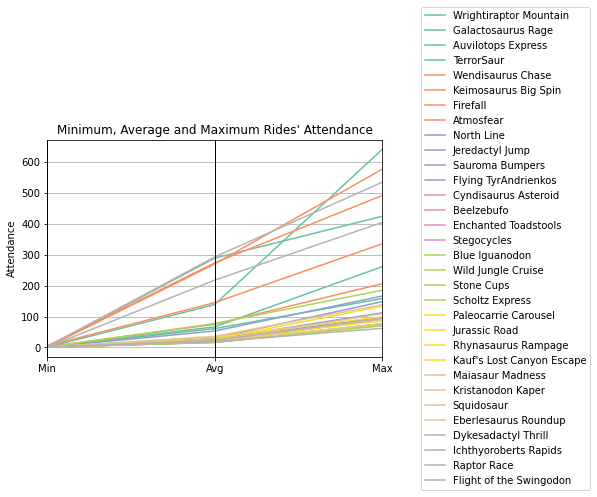

In [21]:
import numpy as np
from pandas.plotting import parallel_coordinates

column_names = ["AttractionID", "Name", "Min", "Avg", "Max"]

ride_plot = pd.DataFrame(columns = column_names)
ride_plot['AttractionID'] = ride_record['AttractionID']
ride_plot['Name'] = ride_record['Name']
for key in ride_freq:
    masked_a = np.ma.masked_equal(ride_freq[key], 0, copy=False)
    ride_plot.loc[ride_plot['AttractionID'] == int(key), 'Avg'] = (sum(ride_freq[key]) / len(ride_freq[key]))
    ride_plot.loc[ride_plot['AttractionID'] == int(key), 'Min'] = masked_a.min()
    ride_plot.loc[ride_plot['AttractionID'] == int(key), 'Max'] = masked_a.max()

parallel_coordinates(ride_plot, 'Name', cols=["Min", "Avg", "Max"], colormap=plt.get_cmap("Set2"))
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.ylabel('Attendance')
plt.title("Minimum, Average and Maximum Rides' Attendance")
plt.savefig("parallel_coordinates.png", bbox_inches='tight')
plt.show()


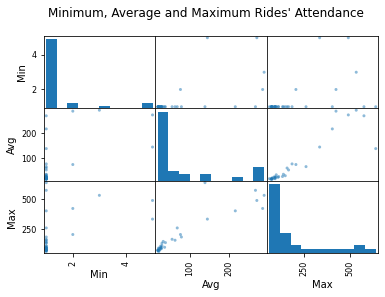

In [19]:
df = pd.DataFrame({'Min':ride_plot["Min"].values.tolist(),
                   'Avg':ride_plot["Avg"].values.tolist(),
                   'Max':ride_plot["Max"].values.tolist()})
pd.plotting.scatter_matrix(df)
plt.suptitle("Minimum, Average and Maximum Rides' Attendance")
plt.savefig("scatter_matrix.png", bbox_inches='tight')
plt.show()

